In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Let's check the list of objects

**Mask-RCNN Starter Model for the Airbus Ship Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

We get some amazing performance training only within the 6hrs kaggle kernel limit.

Now we have the Images which have more classes, Let's use them to build our model

In [0]:
debug = True

In [3]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import datetime
import skimage.draw

from PIL import Image, ImageDraw


Using TensorFlow backend.


In [0]:
DATA_DIR = '/content/drive/My Drive/Capstone/'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [5]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 11.20 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
# Import Mask RCNN
sys.path.append(os.path.join('.', 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [0]:
# train_dicom_dir = os.path.join(DATA_DIR, 'train_color')
# test_dicom_dir = os.path.join(DATA_DIR, 'test')

train_dicom_dir = '/content/drive/My Drive/Capstone References/train'
test_dicom_dir = '/content/drive/My Drive/Capstone References/val'


### Download COCO pre-trained weights

In [8]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [115]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'CVPR Image Instance Segmentation'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 4  # background and Vehicle classes annotated
    
    # To be explored
    # IMAGE_MIN_DIM = 384
    # IMAGE_MAX_DIM = 384

    # to be changed, check the image shape outcome
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384

    RPN_ANCHOR_SCALES = (8, 16, 32, 64)

    TRAIN_ROIS_PER_IMAGE = 64

    # Maximum Ground Truth Instances
    # MAX_GT_INSTANCES = 14
    MAX_GT_INSTANCES = 40

    # DETECTION_MAX_INSTANCES = 10
    DETECTION_MAX_INSTANCES = 30

    # DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_MIN_CONFIDENCE = 0.6

    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    # Look for the significance
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        30
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

Lets create Encode and Decode mapping functions

In [10]:
from PIL import Image
from sklearn.model_selection import train_test_split

# exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
#                 '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
#                 'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
#                 'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir)]
test_names = [f for f in os.listdir(test_dicom_dir) ]

print(len(train_names), len(test_names))

2 2


In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """
  
    #valuedict = {value:key for key, value in classdict_new.items()} 

    def load_data(self, annotation_json, images_dir):
        
 

        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        source_name = "CVPR"

        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            self.add_class(source_name, class_id, class_name)

        annotations = {}
        for annotation in coco_json['annotations']:
          #print(annotation)
          
          image_id = annotation['image_id']
          if image_id not in annotations:
            annotations[image_id] = []
          annotations[image_id].append(annotation)
        #print(annotations)


        image_annotations = []
        seen_images = {}

        # print("No. of images : ", len(coco_json['images']))
        for image in coco_json['images']:
          image_id = image['id']
          # print("image_id : ", image_id)
          if image_id in seen_images:
            print("Warning: Skipping duplicate image id: {}".format(image))
          else:
            seen_images[image_id] = image
            try:
              image_file_name = image['file_name']
              image_width = image['width']
              image_height = image['height']
            except KeyError as key:
              print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
            image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
            print(image_path)
            image_annotations = annotations[str(image_id)]
            # image_annotations.append(annotations[str(image_id)])
            

            self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
            )



    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        # print(len(annotations))
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            # print(annotation)
            # print(annotation['id'])
            # print(annotation['category_id'])
            # print(annotation['segmentation'])
            
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            #for segmentation in annotation['segmentation']:
            #print("segmentation : ", annotation['segmentation'])
            mask_draw.polygon(annotation['segmentation'], fill=1)
            bool_array = np.array(mask) > 0
            instance_masks.append(bool_array)
            class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [0]:
# Json Files are generated using VGG Image Annotation tool and exported using "Export Annotations (COCO Format)"
# Annotations must be done for all the images to Train, then a part of it has to be split in to train and validation

In [138]:
dataset_train = DetectorDataset()
dataset_train.load_data('/content/drive/My Drive/Capstone References/CVPR_COCO_NEW.json', '/content/drive/My Drive/Capstone References/train')
dataset_train.prepare()

dataset_val = DetectorDataset()
dataset_val.load_data('/content/drive/My Drive/Capstone References/CVPR_COCO_NEW.json', '/content/drive/My Drive/Capstone References/val')
dataset_val.prepare()

/content/drive/My Drive/Capstone References/train/170908_062236569_Camera_5.jpg
/content/drive/My Drive/Capstone References/train/170908_062236569_Camera_6.jpg
/content/drive/My Drive/Capstone References/val/170908_062236569_Camera_5.jpg
/content/drive/My Drive/Capstone References/val/170908_062236569_Camera_6.jpg


### Create and prepare the training dataset using the DetectorDataset class.

### Display a random image with bounding boxes

0
/content/drive/My Drive/Capstone References/val/170908_062236569_Camera_5.jpg


(-0.5, 3383.5, 2709.5, -0.5)

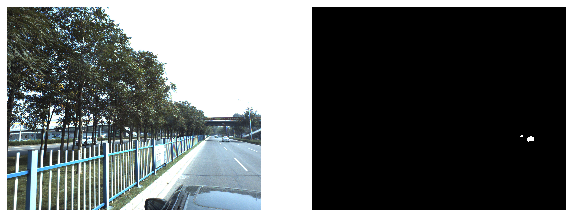

In [139]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    # image_id = 1
    print(image_id)
    image_fp = dataset_val.image_reference(image_id)
    print(image_fp)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
#print(np.zeros(image.shape[:2]).shape)
#print(mask.shape)

masked = np.zeros(image.shape[:2])

for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
    #print(np.unique(masked,return_counts=True))

plt.imshow(masked, cmap='gray')
plt.axis('off')


### Image Augmentation. Try finetuning some variables to custom values

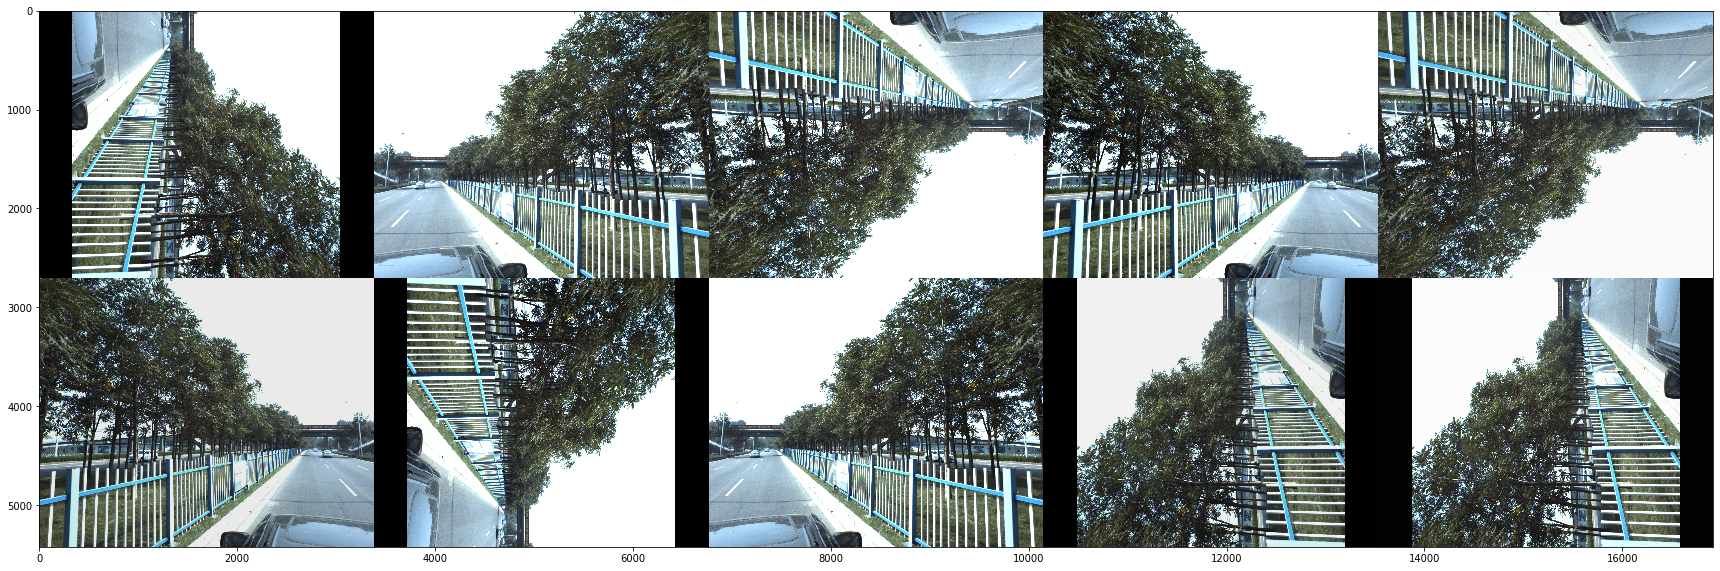

In [149]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
        iaa.Affine(rotate=180),
        iaa.Affine(rotate=270),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image, cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid.astype(int))

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='.')

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [0]:
LEARNING_RATE = 0.003
# LEARNING_RATE = 0.003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [142]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./cvpr image instance segmentation20191220T0603/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

In [0]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=10,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0006

Checkpoint Path: ./cvpr image instance segmentation20191216T0922/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       

In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=4 if debug else 14,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.003

Checkpoint Path: ./cvpr image instance segmentation20191213T0455/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=6 if debug else 22,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.0015

Checkpoint Path: ./cvpr image instance segmentation20191213T0627/mask_rcnn_cvpr image instance segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b

In [0]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,8.431841,3.519540,2.063420,1.326269,0.732870,0.789740,14.433393,8.867972,1.844300,2.002891,0.848174,0.870055
2,5.556411,2.319745,1.610565,0.543260,0.551271,0.531569,6.676472,2.734966,1.682197,1.008634,0.606883,0.643791
3,9.155695,4.825883,1.778656,0.926952,0.857551,0.766647,16.342194,9.268520,1.894056,3.382342,0.890501,0.906769
4,7.578070,3.953314,1.766292,0.677565,0.586560,0.594333,8.137044,3.736251,1.742234,1.119392,0.791762,0.747399
5,6.383708,2.996309,1.793065,0.648395,0.455042,0.490891,6.976732,3.045743,1.739254,0.916987,0.624926,0.649816
6,6.206995,2.631921,1.616873,1.100666,0.429025,0.428503,5.997476,2.504316,1.606308,0.832999,0.523049,0.530797
7,9.866604,5.493044,1.840218,0.602087,0.955597,0.975652,17.000015,10.974879,1.788464,2.307216,0.887550,1.041899
8,7.762614,3.541713,1.811592,0.745412,0.765166,0.898725,8.943633,4.239342,1.868230,1.056007,0.845480,0.934568
9,6.005672,2.543232,1.482004,0.532048,0.631808,0.816573,7.219264,2.960869,1.814039,0.889990,0.702376,0.851984
10,5.598338,2.111465,1.735348,0.457958,0.556324,0.737237,6.855828,2.966559,1.668609,0.754613,0.661836,0.804203


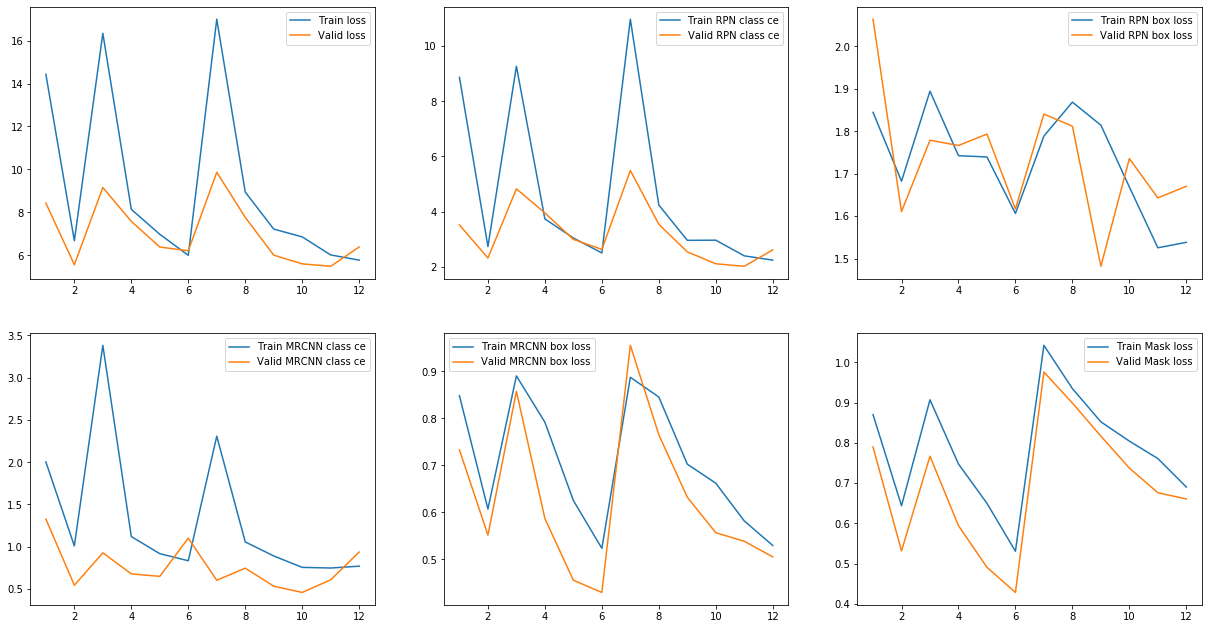

In [0]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [0]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:11 val_loss:5.485490560531616


In [0]:
# # select trained model 
# dir_names = next(os.walk(model.model_dir))[1]
# print("dir_names",dir_names)
# key = config.NAME.lower()
# dir_names = filter(lambda f: f.startswith(key), dir_names)
# dir_names = sorted(dir_names)

# if not dir_names:
#     import errno
#     raise FileNotFoundError(
#         errno.ENOENT,
#         "Could not find model directory under {}".format(self.model_dir))

# fps = []
# # Pick last directory
# for d in dir_names: 
#     print("model_dir :",model.model_dir)
#     dir_name = os.path.join(model.model_dir, d)
#     print("dir_name :",dir_name)
#     # Find the last checkpoint
#     checkpoints = next(os.walk(dir_name))[2]
#     print("checkpoints 1 : ", checkpoints)
#     checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
#     checkpoints = sorted(checkpoints)
#     if not checkpoints:
#         print('No weight files in {}'.format(dir_name))
#     else:
        
#         print("checkpoints :",checkpoints)
#         print("best_epoch :",best_epoch)
#         checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
#         fps.append(checkpoint)

# model_path = sorted(fps)[-1]
# print('Found model {}'.format(model_path))

In [0]:
model_path = '/content/Mask_RCNN/cvpr image instance segmentation20191220T0603/mask_rcnn_cvpr image instance segmentation_0002.h5'

In [144]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='.')

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/cvpr image instance segmentation20191220T0603/mask_rcnn_cvpr image instance segmentation_0002.h5


In [0]:
# # set color for class
# def get_colors_for_class_ids(class_ids):
#     colors = []
#     for class_id in class_ids:
#         if class_id == 1:
#             colors.append((.941, .204, .204))
        

#     return colors

In [0]:

# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:

        colors.append((round(random.random(),3), round(random.random(),3), round(random.random(),3)))
        
    return colors

In [0]:
(round(random.random(),3), round(random.random(),3), round(random.random(),3))

(0.91, 0.866, 0.207)

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

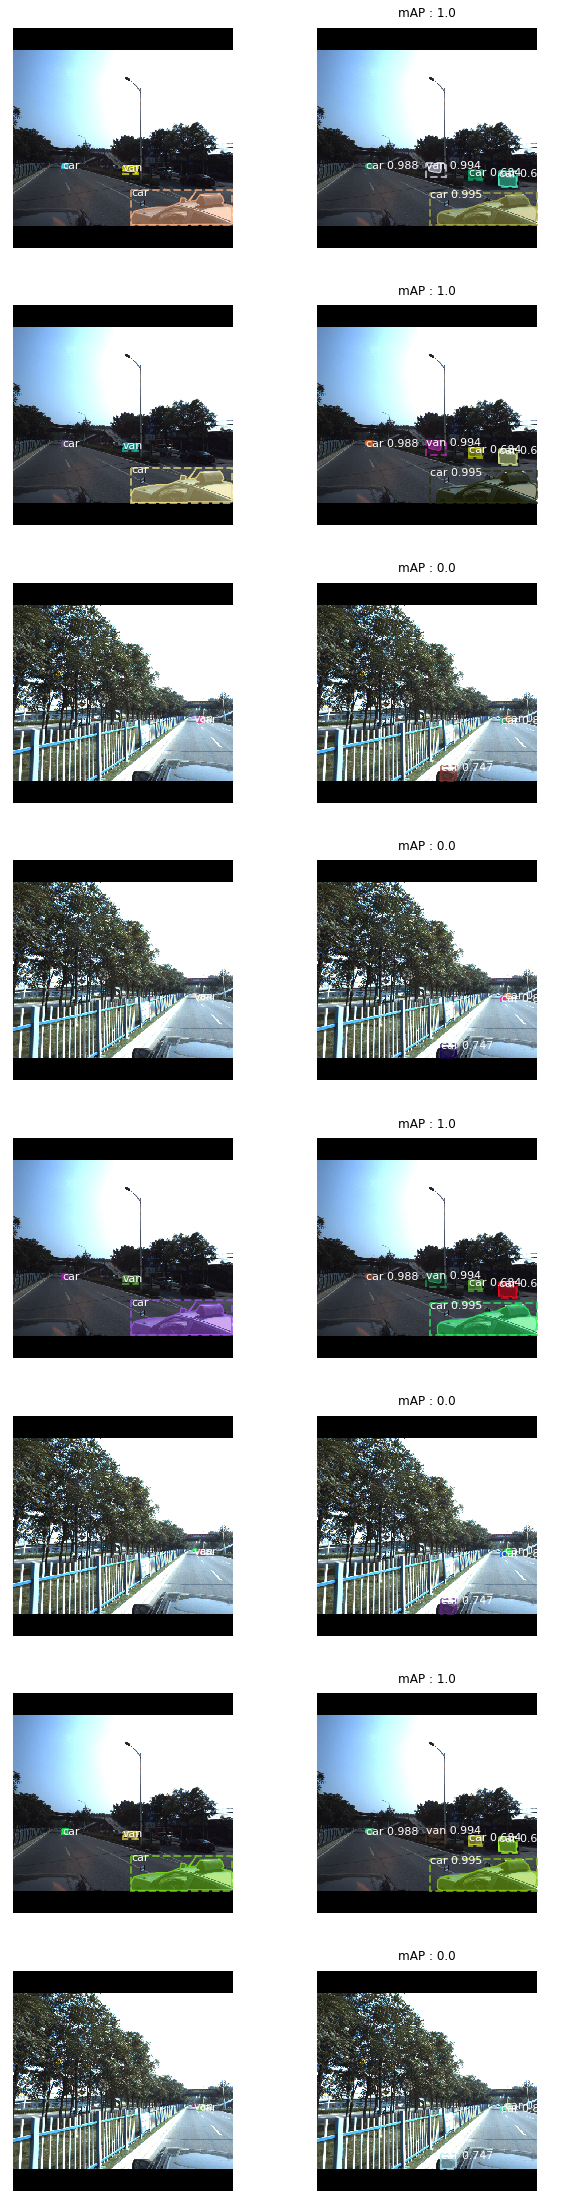

In [146]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    
    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,r['rois'], r['class_ids'], r['scores'], r['masks'],
               iou_threshold=0.5)
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1], title = "mAP : " + str(mAP))
    

    

In [0]:
import numpy as np

In [0]:

dataset = dataset_val
fig = plt.figure(figsize=(10, 40))
AvgmAP = []
for i in range(100):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    

    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    

    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
               r['rois'], r['class_ids'], r['scores'], r['masks'],
               iou_threshold=0.5)
    AvgmAP.append(mAP)

    
print("Average mAP : ", np.average(AvgmAP)  )

Average mAP :  0.21078994708411553


<Figure size 720x2880 with 0 Axes>

Model Evaluation

In [0]:
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        #AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls


mAP @ IoU=50:  [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]


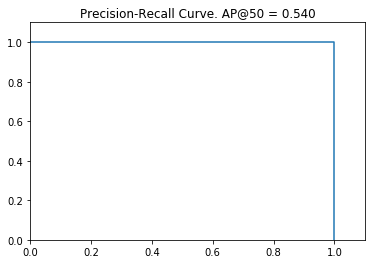

In [148]:
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()